# Signature Verification Using Siamese Network

This notebook demonstrates how to implement signature verification using a Siamese Network. A Siamese Network is a type of neural network architecture that uses two identical subnetworks, each taking one of the two input signatures. The networks are joined at their outputs by a similarity function. The objective is to learn a similarity metric between the outputs of the two subnetworks. This metric can then be used to determine if the two input signatures belong to the same person. This approach is particularly useful for tasks like signature verification where the number of samples per class is limited.

# Import Libraries

In [2]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

In [3]:
# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Helper Functions

In [14]:
def load_images(dataset_path):
    """
    Loads and preprocesses signature images from specified genuine and forged folders.

    Args:
        dataset_path (str): The root path of the dataset containing 'genuine' and 'forged' subfolders.

    Returns:
        tuple: A tuple containing three NumPy arrays:
            - images (np.ndarray): A NumPy array of preprocessed signature images
              (resized to 128x128, grayscale, and normalized to [0, 1]).
            - labels (np.ndarray): A NumPy array of labels, where 1 represents genuine
              signatures and 0 represents forged signatures.
            - person_ids (np.ndarray): A NumPy array of integer IDs representing the
              person whose signature the image belongs to, extracted from the filename.
    """
    images = []
    labels = []
    person_ids = []

    # Load genuine signatures
    genuine_folder = os.path.join(dataset_path, 'genuine')
    for filename in os.listdir(genuine_folder):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            # Read image
            img_path = os.path.join(genuine_folder, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (128, 128))
            img = img.astype('float32') / 255.0

            # Parse filename: NFI-XXXYYZZZ
            name_part = filename.split('.')[0].replace('NFI-', '')
            person_id = int(name_part[5:8])  # Last 3 digits = whose signature

            images.append(img)
            labels.append(1)  # 1 = genuine
            person_ids.append(person_id)

    # Load forged signatures
    forged_folder = os.path.join(dataset_path, 'forged')
    for filename in os.listdir(forged_folder):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            # Read image
            img_path = os.path.join(forged_folder, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (128, 128))
            img = img.astype('float32') / 255.0

            # Parse filename
            name_part = filename.split('.')[0].replace('NFI-', '')
            person_id = int(name_part[5:8])  # Last 3 digits = whose signature

            images.append(img)
            labels.append(0)  # 0 = forged
            person_ids.append(person_id)

    print(f"Loaded {len(images)} images")
    print(f"Genuine: {sum(labels)}, Forged: {len(labels) - sum(labels)}")

    return np.array(images), np.array(labels), np.array(person_ids)

In [24]:
def visualize_samples(images, labels, person_ids, num_samples=3):
  """
    Visualizes sample genuine and forged signatures.

    Args:
        images (np.ndarray): Array of preprocessed signature images.
        labels (np.ndarray): Array of labels (1 for genuine, 0 for forged).
        person_ids (np.ndarray): Array of person IDs corresponding to each image.
        num_samples (int, optional): The number of samples to display for each class. Defaults to 3.
  """
  genuine_indices = np.where(labels == 1)[0]
  forged_indices = np.where(labels == 0)[0]

  # Select a few random indices to display
  genuine_sample_indices = np.random.choice(genuine_indices, num_samples, replace=False)
  forged_sample_indices = np.random.choice(forged_indices, num_samples, replace=False)

  plt.figure(figsize=(12, 6))

  # Display genuine samples
  for i, idx in enumerate(genuine_sample_indices):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(images[idx], cmap='gray')
    plt.title(f'Genuine (ID: {person_ids[idx]})')
    plt.axis('off')

  # Display forged samples
  for i, idx in enumerate(forged_sample_indices):
    plt.subplot(2, num_samples, i + num_samples + 1)
    plt.imshow(images[idx], cmap='gray')
    plt.title(f'Forged (ID: {person_ids[idx]})')
    plt.axis('off')

  plt.suptitle('Sample Genuine and Forged Signatures', y=1.02)
  plt.tight_layout()
  plt.show()

In [5]:
def create_pairs(images, labels, person_ids):
    """
    Creates positive and negative pairs of images for Siamese network training.

    Positive pairs consist of two images from the same person, while negative
    pairs consist of two images from different people. The number of positive
    and negative pairs created is balanced.

    Args:
        images (np.ndarray): A NumPy array of preprocessed signature images.
        labels (np.ndarray): A NumPy array of labels corresponding to images
                             (not directly used for pairing but can be useful
                             for context/debugging).
        person_ids (np.ndarray): A NumPy array of integer IDs representing the
                                 person whose signature each image belongs to.

    Returns:
        tuple: A tuple containing two NumPy arrays:
            - pairs (np.ndarray): A NumPy array of shape (n_pairs, 2, height, width)
              containing the image pairs. Each element is a pair of images.
            - pair_labels (np.ndarray): A NumPy array of shape (n_pairs,)
              containing the labels for each pair, where 1 indicates a positive
              pair (same person) and 0 indicates a negative pair (different people).
    """
    pairs = []
    pair_labels = []

    # Group images by person
    person_groups = {}
    for i, person_id in enumerate(person_ids):
        if person_id not in person_groups:
            person_groups[person_id] = []
        person_groups[person_id].append(i)

    # Create positive pairs (same person)
    for person_id, indices in person_groups.items():
        if len(indices) > 1:
            for i in range(len(indices)):
                for j in range(i+1, len(indices)):
                    pairs.append([images[indices[i]], images[indices[j]]])
                    pair_labels.append(1)  # Same person

    # Create negative pairs (different people)
    person_list = list(person_groups.keys())
    num_negative = len(pair_labels)  # Same number as positive pairs

    for _ in range(num_negative):
        # Pick two different people
        person1, person2 = random.sample(person_list, 2)
        idx1 = random.choice(person_groups[person1])
        idx2 = random.choice(person_groups[person2])

        pairs.append([images[idx1], images[idx2]])
        pair_labels.append(0)  # Different people

    print(f"Created {len(pairs)} pairs")
    print(f"Same person pairs: {sum(pair_labels)}")
    print(f"Different person pairs: {len(pair_labels) - sum(pair_labels)}")

    return np.array(pairs), np.array(pair_labels)

In [6]:
def build_base_network():
    """
    Builds the Convolutional Neural Network (CNN) base network for feature extraction.

    This network consists of convolutional layers followed by max pooling layers
    to extract spatial features, and then dense layers to further process
    the features into a fixed-size embedding vector. This base network will
    be used as the shared subnetwork in the Siamese architecture.

    Returns:
        tf.keras.Model: A Keras Model that takes a single grayscale image (128x128x1)
                        as input and outputs a 128-dimensional feature vector.
    """
    input_layer = layers.Input(shape=(128, 128, 1))

    # Convolutional layers
    x = layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)

    return Model(input_layer, x)

In [7]:
def euclidean_distance(vectors):
    """
    Calculates the Euclidean distance between two batches of vectors.

    Args:
        vectors (tuple): A tuple containing two tensors, `x` and `y`,
                         each representing a batch of vectors. Both tensors
                         should have the same shape except potentially the
                         last dimension if broadcasting is intended (though
                         this function assumes the last dimension is where
                         the distance is calculated).

    Returns:
        tf.Tensor: A tensor of shape `(batch_size, 1)` representing the
                   Euclidean distance between corresponding vectors in the
                   input batches.
    """
    x, y = vectors
    return tf.sqrt(tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True))

In [8]:
def build_siamese_network():
    """
    Builds the complete Siamese network for signature verification.

    The network consists of two identical base networks (CNNs) that share
    weights, which process the two input images. The outputs of the base
    networks are then fed into a layer that computes their Euclidean distance.
    Finally, a dense layer with a sigmoid activation predicts the probability
    that the two input signatures belong to the same person.

    The Siamese network takes a pair of grayscale images of shape (128, 128, 1)
    as input.

    Returns:
        tf.keras.Model: A Keras Model representing the complete Siamese network.
                        It takes a list of two input tensors ([input_a, input_b])
                        and outputs a single tensor representing the predicted
                        similarity score (probability).
    """
    # Base network
    base_network = build_base_network()

    # Input layers for image pairs
    input_a = layers.Input(shape=(128, 128, 1))
    input_b = layers.Input(shape=(128, 128, 1))

    # Process both images through base network
    processed_a = base_network(input_a)
    processed_b = base_network(input_b)

    # Calculate distance
    distance = layers.Lambda(euclidean_distance)([processed_a, processed_b])

    # Final prediction layer
    output = layers.Dense(1, activation='sigmoid')(distance)

    return Model([input_a, input_b], output)

In [9]:
def train_model(pairs, pair_labels):
    """
    Trains the Siamese network on the provided image pairs and their labels.

    The function splits the data into training and testing sets, separates the
    left and right images for the Siamese inputs, adds the channel dimension,
    builds and compiles the Siamese model, trains the model, and evaluates it
    on the test set.

    Args:
        pairs (np.ndarray): A NumPy array of shape (n_pairs, 2, height, width)
            containing the image pairs. Each element is a pair of images
            (left_image, right_image).
        pair_labels (np.ndarray): A NumPy array of shape (n_pairs,)
            containing the labels for each pair, where 1 indicates a positive
            pair (same person) and 0 indicates a negative pair (different people).

    Returns:
        tuple: A tuple containing the trained Keras Model and the training history.
            - model (tf.keras.Model): The trained Siamese network model.
            - history (tf.keras.callbacks.History): The history object returned by
              model.fit(), containing training and validation metrics.
    """
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        pairs, pair_labels, test_size=0.2, random_state=42
    )

    # Separate left and right images
    X_train_left = X_train[:, 0]
    X_train_right = X_train[:, 1]
    X_test_left = X_test[:, 0]
    X_test_right = X_test[:, 1]

    # Add channel dimension
    X_train_left = X_train_left.reshape(-1, 128, 128, 1)
    X_train_right = X_train_right.reshape(-1, 128, 128, 1)
    X_test_left = X_test_left.reshape(-1, 128, 128, 1)
    X_test_right = X_test_right.reshape(-1, 128, 128, 1)

    # Build and compile model
    model = build_siamese_network()
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    print("Model summary:")
    model.summary()

    # Train model
    print("Training model...")
    history = model.fit(
        [X_train_left, X_train_right], y_train,
        validation_data=([X_test_left, X_test_right], y_test),
        epochs=30,
        batch_size=32,
        verbose=1
    )

    # Evaluate model
    test_loss, test_accuracy = model.evaluate([X_test_left, X_test_right], y_test)
    print(f"Test Accuracy: {test_accuracy:.4f}")

    return model, history

In [10]:
def plot_training(history):
    """
    Plots the training and validation loss and accuracy curves over epochs.

    This function takes the history object returned by the `model.fit()` method
    and generates two plots side-by-side: one for loss and one for accuracy.
    It shows how the model performed on both the training and validation datasets
    throughout the training process.

    Args:
        history (tf.keras.callbacks.History): The history object returned by
                                              `model.fit()`, containing metrics
                                              like 'loss', 'val_loss', 'accuracy',
                                              and 'val_accuracy' for each epoch.
    """
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [26]:
def verify_signatures(model, img1_path, img2_path):
  """
  Verifies if two signatures belong to the same person using a trained model
  and visualizes the signature images used for verification.

  This function takes a trained Siamese network model and paths to two
  signature image files as input. It loads, preprocesses, and feeds the
  images through the model to obtain a similarity score. Based on a predefined
  threshold, it determines if the signatures are from the same person and
  prints the similarity score and the verification result. Finally, it displays
  the two signature images side-by-side.

  Args:
    model (tf.keras.Model): The trained Siamese network model used for
                            signature verification. The model is expected to
                            take two image inputs and output a similarity score
                            between 0 and 1 (or similar range that can be
                            thresholded).
    img1_path (str): The file path to the first signature image.
    img2_path (str): The file path to the second signature image.

  Returns:
    tuple: A tuple containing:
      - is_same_person (bool): True if the signatures are predicted to be
                               from the same person, False otherwise.
      - similarity (float): The similarity score predicted by the model.
  """
  # Load and preprocess images
  img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
  original_img1 = cv2.imread(img1_path, cv2.IMREAD_COLOR) # Keep color for display
  img1_resized = cv2.resize(img1, (128, 128))
  img1_processed = img1_resized.astype('float32') / 255.0
  img1_input = img1_processed.reshape(1, 128, 128, 1)

  img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)
  original_img2 = cv2.imread(img2_path, cv2.IMREAD_COLOR) # Keep color for display
  img2_resized = cv2.resize(img2, (128, 128))
  img2_processed = img2_resized.astype('float32') / 255.0
  img2_input = img2_processed.reshape(1, 128, 128, 1)

  # Predict similarity
  similarity = model.predict([img1_input, img2_input])[0][0]

  # Threshold for decision
  threshold = 0.5
  is_same_person = similarity > threshold

  print(f"Similarity score: {similarity:.4f}")
  if is_same_person:
    print("Result: Same person")
  else:
    print("Result: Different person")

  # Visualize the images used for verification
  plt.figure(figsize=(10, 5))

  plt.subplot(1, 2, 1)
  plt.imshow(cv2.cvtColor(original_img1, cv2.COLOR_BGR2RGB))
  plt.title(f'Image 1: {os.path.basename(img1_path)}')
  plt.axis('off')

  plt.subplot(1, 2, 2)
  plt.imshow(cv2.cvtColor(original_img2, cv2.COLOR_BGR2RGB))
  plt.title(f'Image 2: {os.path.basename(img2_path)}')
  plt.axis('off')

  plt.suptitle('Signature Images for Verification', y=1.02)
  plt.tight_layout()
  plt.show()


  return is_same_person, similarity

# Signature Verification System

In [12]:
# Path to dataset
dataset_path = "/content/drive/MyDrive/sample_Signature"

In [15]:
# Load data
print("Loading images...")
images, labels, person_ids = load_images(dataset_path)

Loading images...
Loaded 240 images
Genuine: 120, Forged: 120


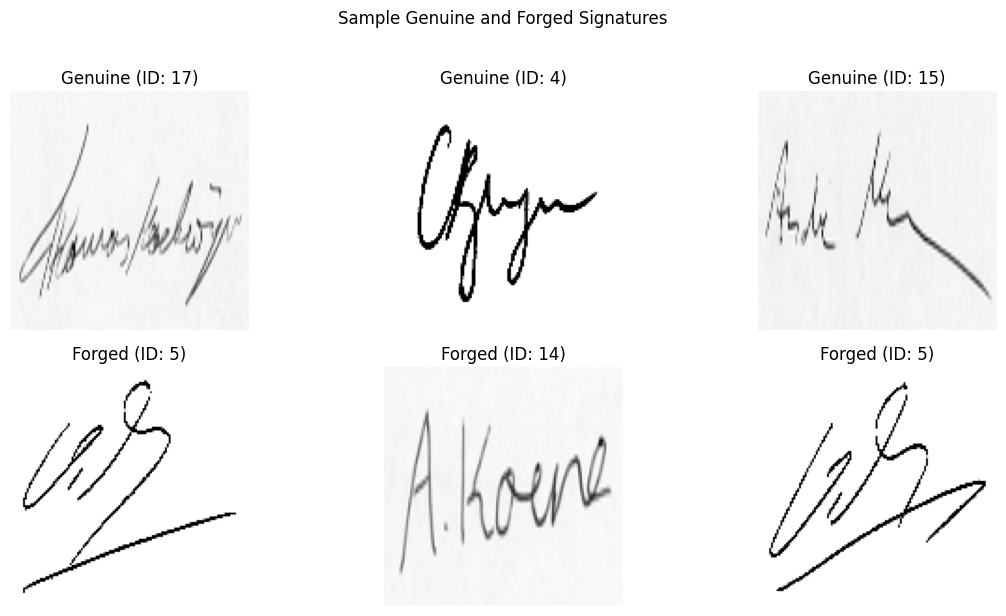

In [25]:
# Visualize a sample of the data
visualize_samples(images, labels, person_ids)

In [16]:
# Create pairs
print("Creating pairs...")
pairs, pair_labels = create_pairs(images, labels, person_ids)

Creating pairs...
Created 2162 pairs
Same person pairs: 1081
Different person pairs: 1081


In [17]:
# Train model
print("Training model...")
model, history = train_model(pairs, pair_labels)

Training model...
Model summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 128)       │  6,548,352 │ input_layer_1[0]… │
│ (Functional)        │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ functional[0][0], │
│                     │                   │            │ functional[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │          2 │ lambda[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,548,354 (24.98 MB)

 Trainable params: 6,548,354 (24.98 MB)

 Non-trainable params: 0 (0.00 B)

Training model...
Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 115ms/step - accuracy: 0.4830 - loss: 0.5617 - val_accuracy: 0.5543 - val_loss: 0.5183
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5784 - loss: 0.5162 - val_accuracy: 0.6374 - val_loss: 0.5025
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.6527 - loss: 0.5115 - val_accuracy: 0.7136 - val_loss: 0.4863
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7285 - loss: 0.5013 - val_accuracy: 0.7229 - val_loss: 0.4863
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7351 - loss: 0.4938 - val_accuracy: 0.8360 - val_loss: 0.4621
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8205 - loss: 0.4637 - val_accuracy: 0.8337 - val_loss: 0.4416
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8407 - loss: 0.4517 - val_accuracy: 0.8868 - val_loss: 0.4223
Epoch 8/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8751 - loss: 0.4361 - val_

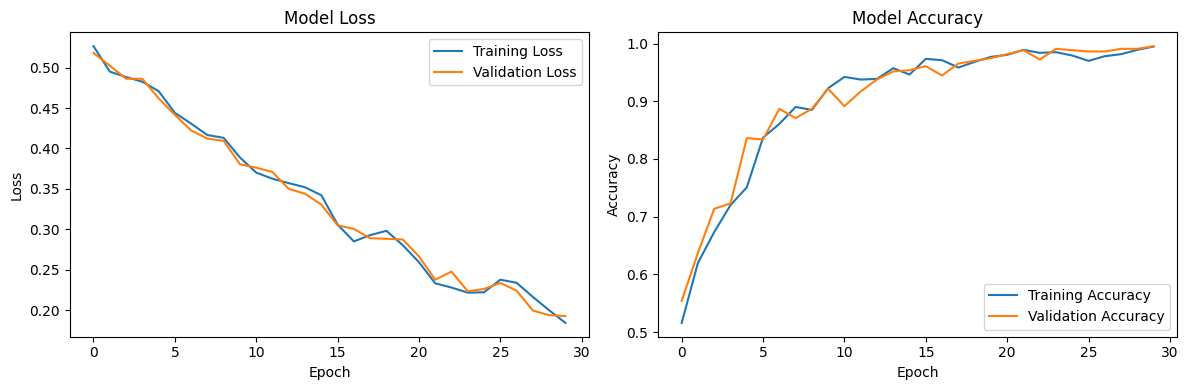

In [18]:
# Plot results
plot_training(history)

In [19]:
# Save model
model.save('signature_verification_model.h5')
print("Model saved as 'signature_verification_model.h5'")

Model saved as 'signature_verification_model.h5'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Similarity score: 0.0001
Result: Different person


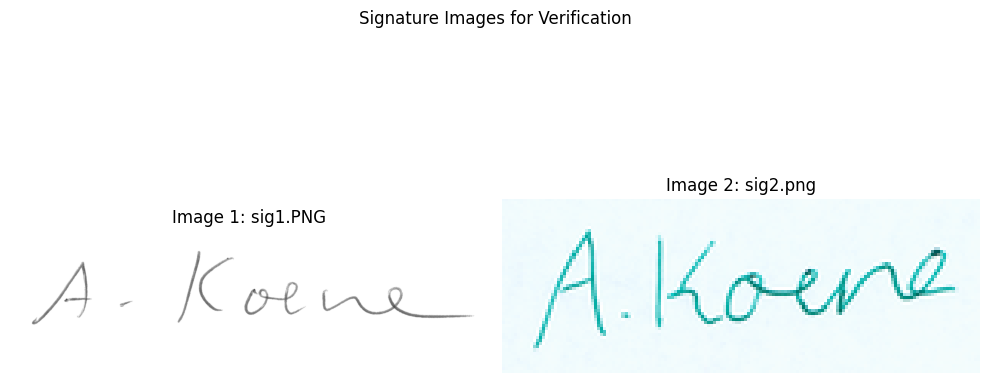

In [27]:
# Example verification
is_same, score = verify_signatures(model, '/content/sig1.PNG', '/content/sig2.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Similarity score: 0.6876
Result: Same person


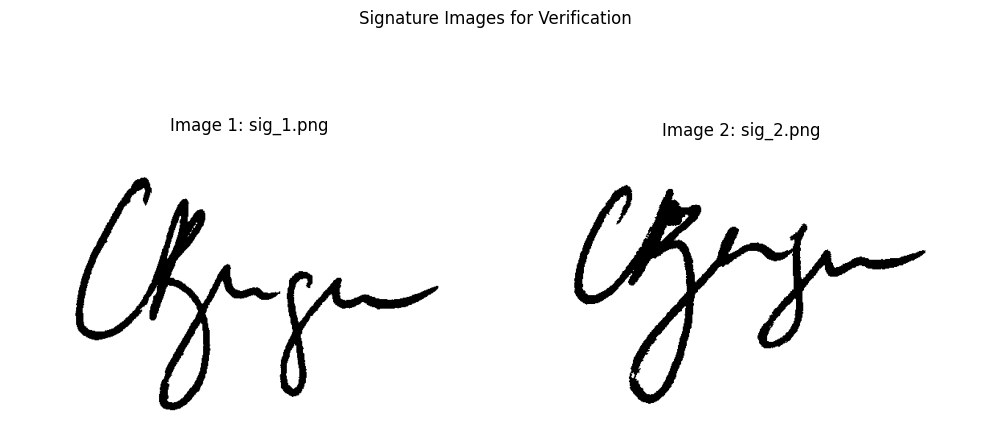

In [28]:
# Example verification
is_same, score = verify_signatures(model, '/content/sig_1.png', '/content/sig_2.png')